In [3]:
%config InlineBackend.figure_formats = ['svg']

In [4]:
import numpy as np

import matplotlib.pyplot as plt
COLORS = ['#648fff', '#785ef0', '#dc267f', '#fe6100']

In [5]:
PLANCK_CONSTANT = 1

mass = 0.5
lattice_wavenumber = 1
lattice_spacing = 2*np.pi/lattice_wavenumber

recoil_energy = (PLANCK_CONSTANT**2 *  lattice_wavenumber**2)/(2 * mass)

In [6]:
min_harmonic = -25
max_harmonic = 25
num_harmonics = max_harmonic - min_harmonic + 1

harmonics = range(min_harmonic, max_harmonic + 1)
def harmonic_to_index(harmonic):
    return harmonic - min_harmonic

min_quasimomentum = -PLANCK_CONSTANT * lattice_wavenumber
max_quasimomentum = PLANCK_CONSTANT * lattice_wavenumber
num_quasimomentums = 1000

quasimomentum_range = max_quasimomentum - min_quasimomentum
quasimomentum_resolution = quasimomentum_range / num_quasimomentums
quasimomentums = np.linspace(min_quasimomentum, max_quasimomentum, num_quasimomentums)

min_site = -2
max_site = 2
num_sites = max_site - min_site + 1
sites = np.arange(min_site, max_site + 1) * np.pi/lattice_wavenumber
site_positions = sites * np.pi/lattice_wavenumber

min_position = min_site * lattice_spacing/2
max_position = max_site * lattice_spacing/2
num_positions = 1000

position_range = max_position - min_position
position_resolution = position_range / num_positions
positions = np.linspace(min_position, max_position, num_positions)

In [7]:
def compute_potential(lattice_depth):
    return -lattice_depth * np.cos(lattice_wavenumber * positions) ** 2

In [8]:
def compute_potential_amplitudes(lattice_depth):
    potential_amplitudes = np.zeros(num_harmonics)
    for harmonic in (-1, 1):
        potential_amplitudes[harmonic_to_index(harmonic)] = -lattice_depth/4
    return potential_amplitudes

In [9]:
def compute_transition_energies(potential_amplitudes):
    transition_energies = np.zeros((num_quasimomentums, num_harmonics, num_harmonics), dtype=complex)
    for quasimomentum_index, quasimomentum in enumerate(quasimomentums):
        for this_harmonic in harmonics:
            this_index = harmonic_to_index(this_harmonic)
            transition_energies[quasimomentum_index][this_index][this_index] += (2*this_harmonic + quasimomentum/(PLANCK_CONSTANT * lattice_wavenumber)) ** 2 * recoil_energy
            for that_harmonic in harmonics:
                that_index = harmonic_to_index(that_harmonic)
                potential_amplitude_index = harmonic_to_index(this_harmonic - that_harmonic)
                if 0 < potential_amplitude_index < num_harmonics:
                    transition_energies[quasimomentum_index][this_index][that_index] += potential_amplitudes[potential_amplitude_index]
    return transition_energies

In [10]:
def eigendecompose(transition_energies):
    energies = np.zeros((num_harmonics, num_quasimomentums))
    stationary_periodic_component_amplitudes = np.zeros((num_harmonics, num_quasimomentums, num_harmonics), dtype=complex)
    for quasimomentum_index, quasimomentum in enumerate(quasimomentums):
        raw_energies, raw_stationary_periodic_component_amplitudes = np.linalg.eigh(transition_energies[quasimomentum_index])
        for band_index, (energy, stationary_periodic_component_amplitude_vector) in enumerate(zip(raw_energies, np.transpose(raw_stationary_periodic_component_amplitudes))):
            energies[band_index][quasimomentum_index] = energy
            stationary_periodic_component_amplitudes[band_index][quasimomentum_index] = stationary_periodic_component_amplitude_vector
    return energies, stationary_periodic_component_amplitudes

In [11]:
def normalize(wavefunctions):
    return (wavefunctions * 1/np.sqrt(np.sum(np.abs(wavefunctions)**2 * position_resolution, axis=-1))[:, np.newaxis])

In [12]:
def density(wavefunctions):
    return np.abs(wavefunctions) ** 2

In [13]:
def compute_stationary_wavefunctions(periodic_component_amplitudes):
    return normalize(np.multiply(np.exp(1j * np.tensordot(quasimomentums, positions, axes=0) / PLANCK_CONSTANT), np.dot(periodic_component_amplitudes, np.exp(1j * np.tensordot(2 * np.array(harmonics), lattice_wavenumber * positions, axes=0)))))

In [14]:
# def compute_localized_wavefunctions(stationary_wavefunctions):
#     wavefunctions = np.tensordot(np.exp(-1j * np.tensordot(site_positions, quasimomentums, axes=0) / PLANCK_CONSTANT), stationary_wavefunctions, axes=(1, 1))
#     return wavefunctions * 1/np.sqrt(np.sum(np.abs(wavefunctions)**2 * position_resolution, axis=-1))[:, :, np.newaxis]

def compute_localized_wavefunctions(stationary_wavefunctions):
    return normalize(np.sum(stationary_wavefunctions, axis=1))

In [15]:
def compute_tunneling_strength(energies):
    return (np.max(energies[0]) - np.min(energies[0])) / 4

In [16]:
def compute_interaction_strength(localized_wavefunctions):
    return np.sum(np.abs(localized_wavefunctions[0])**4 * position_resolution)

In [17]:
def analyze(lattice_depth):
    potential = compute_potential(lattice_depth)
    potential_amplitudes = compute_potential_amplitudes(lattice_depth)
    transition_energies = compute_transition_energies(potential_amplitudes)
    energies, stationary_periodic_component_amplitudes = eigendecompose(transition_energies)
    stationary_wavefunctions = compute_stationary_wavefunctions(stationary_periodic_component_amplitudes)
    localized_wavefunctions = compute_localized_wavefunctions(stationary_wavefunctions)
    tunneling_strength = compute_tunneling_strength(energies)
    interaction_strength = compute_interaction_strength(localized_wavefunctions)
    return potential, energies, stationary_wavefunctions, localized_wavefunctions, tunneling_strength, interaction_strength

In [22]:
def plot_energies(energies, num_bands=4):
    plt.title("Energy Dispersion $E(q)$")
    plt.xlabel("Quasimomentum $q$")
    plt.ylabel("Energy $E$")
    
    for band_energies, color in zip(energies[:num_bands], COLORS):
        plt.plot(quasimomentums, band_energies, color=color)

    plt.show()

In [23]:
def plot_wavefunctions(stationary_wavefunctions, localized_wavefunctions, potential):
    plt.title("Wavefunction $\Re(\psi(x))$")
    plt.xlabel("Position $x$")
    plt.ylabel("Wavefunction $\Re(\psi)$")

    plt.plot(positions, stationary_wavefunctions[0][num_quasimomentums//2].real, label="$\phi_0^{(1)}(x)$", color=COLORS[0])
    plt.plot(positions, stationary_wavefunctions[0][num_quasimomentums-1].real, label="$\phi_{\hbar k}^{(1)}(x)$", color=COLORS[1])
    plt.plot(positions, localized_wavefunctions[0].real, label="$w_1(x)$", color=COLORS[2])
    plt.plot(positions, (potential - np.min(potential))/(-5*np.min(potential)), ':', label="$V(x)$", color=COLORS[3])

    plt.legend()

    plt.show()

In [24]:
def plot_densities(stationary_wavefunctions, localized_wavefunctions, potential):
    plt.title("Density $|\psi(x)|^2$")
    plt.xlabel("Position $x$")
    plt.ylabel("Density $|\psi|^2$")

    plt.plot(positions, density(stationary_wavefunctions[0][num_quasimomentums//2]), label="$\phi_0^{(1)}(x)$", color=COLORS[0])
    plt.plot(positions, density(stationary_wavefunctions[0][num_quasimomentums-1]), label="$\phi_{\hbar k}^{(1)}(x)$", color=COLORS[1])
    plt.plot(positions, density(localized_wavefunctions[0]), label="$w_1(x)$", color=COLORS[2])
    plt.plot(positions, (potential - np.min(potential))/(-10*np.min(potential)), ':', label="$V(x)$", color=COLORS[3])

    plt.legend()

    plt.show()

In [29]:
potential, energies, stationary_wavefunctions, localized_wavefunctions, tunneling_strength, interaction_strength = analyze(0 * recoil_energy)

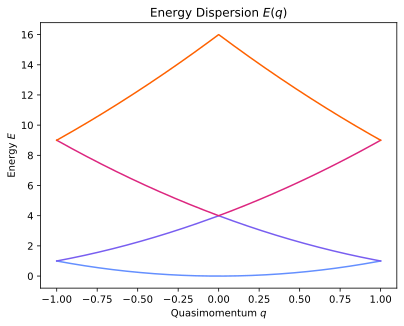

/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_70314/2325332391.py:9: RuntimeWarning: invalid value encountered in divide
  plt.plot(positions, (potential - np.min(potential))/(-5*np.min(potential)), ':', label="$V(x)$", color=COLORS[3])


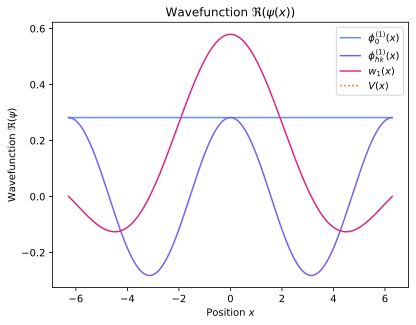

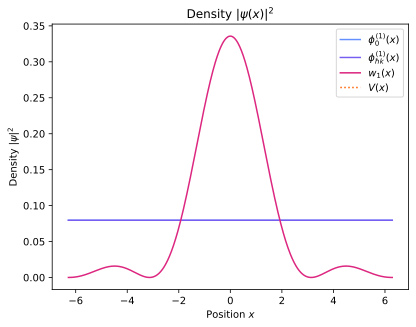

Tunneling Strength: 0.249999749499249, Interaction Strength: 0.23552587491302857


In [30]:
plot_energies(energies)
plot_wavefunctions(stationary_wavefunctions, localized_wavefunctions, potential)
plot_densities(stationary_wavefunctions, localized_wavefunctions, potential)
print(f"Tunneling Strength: {tunneling_strength}, Interaction Strength: {interaction_strength}")

In [111]:
lattice_depths = np.linspace(0, 50, 11) * recoil_energy
lattice_depths

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.])

In [113]:
results = [ analyze(lattice_depth) for lattice_depth in lattice_depths ]

In [120]:
interaction_strengths = np.array([ result[5]  for result in results ])
tunneling_strengths = np.array([ result[4]  for result in results ])

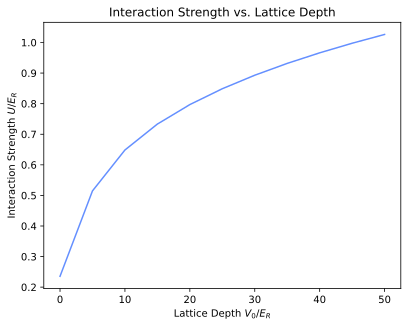

In [129]:
plt.title("Interaction Strength vs. Lattice Depth")
plt.xlabel("Lattice Depth $V_0/E_R$")
plt.ylabel("Interaction Strength $U/E_R$")

plt.plot(lattice_depths, interaction_strengths, color=COLORS[0])

plt.show()

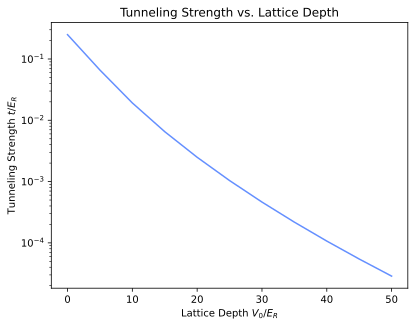

In [125]:
plt.title("Tunneling Strength vs. Lattice Depth")
plt.xlabel("Lattice Depth $V_0/E_R$")
plt.ylabel("Tunneling Strength $t/E_R$")

plt.plot(lattice_depths, tunneling_strengths, color=COLORS[0])
plt.yscale('log')

plt.show()

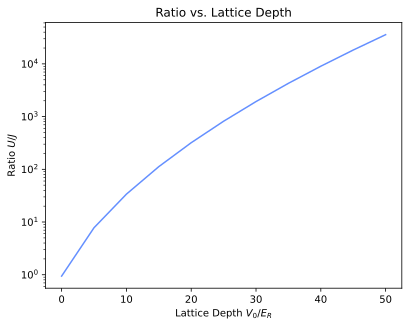

In [130]:
plt.plot(lattice_depths, interaction_strengths / tunneling_strengths, color=COLORS[0])
plt.yscale('log')

plt.title("Ratio vs. Lattice Depth")
plt.xlabel("Lattice Depth $V_0/E_R$")
plt.ylabel("Ratio $U/J$")

plt.show()